## Finding Adjacent Repeats


Given a sequence of numbers, find and mark adjacent repeats. Repeats can be of length 3-10.

```
input  = 0 3 5 9 3 3 5 2 5
output = 0 0 0 0 1 1 0 0 0

input  = 1 2 2 2 2 2 3 1 5
output = 0 1 1 1 1 1 0 0 0

```

In [1]:
import torch
import numpy as np

from radam import RAdam
from torch.utils.data import DataLoader, Dataset
from transformers import BertConfig, BertModel

from utils import train, get_output_for_example, plot_losses

In [2]:
def generate_data(num_examples: int, seq_len: int, vocab_size: int):
    inputs = np.random.randint(0, vocab_size, size=(num_examples, seq_len))
    outputs = np.zeros_like(inputs)
    
    for i in range(len(inputs)):
        
        # choose number of duplicates to introduce
        num_duplicates = np.random.randint(3, 5)
        
        # choose random location to introduce our duplicates
        location = np.random.randint(0, len(inputs[i]) - num_duplicates)
        
        # Choose what number we'd like to repeat
        number_to_repeat = np.random.randint(0, vocab_size)
        
        inputs[i][location:location + num_duplicates] = number_to_repeat
        
        # Mark location where duplicates exist
        outputs[i][location:location + num_duplicates] = 1
        

    return inputs, outputs

In [3]:
# We're lazy so we're going to just use a large vocabulary 
# instead of manually removing accidental duplicates
generate_data(num_examples=1, seq_len=10, vocab_size=1000)

(array([[475, 380, 981, 981, 981, 237, 840,   5, 314, 260]]),
 array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 0]]))

In [4]:
class ToyDataset(Dataset):
   
    def __init__(self, num_examples, sequence_length, vocab_size):
        self.items, self.labels = generate_data(num_examples, sequence_length, vocab_size)
        
    def __getitem__(self, idx):
        
        x = torch.Tensor(self.items[idx]).long()
        y = torch.Tensor(self.labels[idx]).long()
        return x.cuda(), y.cuda()
    
    def __len__(self):
        return len(self.items)

In [5]:
class ToyModel(torch.nn.Module):
    """
    Wrapper around a BERT model that predicts a single binary output for each input token
    """
    
    def __init__(self, vocab_size):
        super().__init__()
        
        # Untrained BERT Model
        config = BertConfig(vocab_size_or_config_json_file=vocab_size)
        self.bert_model = BertModel(config)
        self.linear = torch.nn.Linear(in_features=768, out_features=2)
        
    def forward(self, x):    
        out, _ = self.bert_model(x)
        out = self.linear(out)
        return out    

In [6]:
TRN_EXAMPLES = 10000
VAL_EXAMPLES = 1000
SEQUENCE_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [7]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

optimizer = RAdam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
train_loss, valid_loss, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15)

Epoch:	 0 	Step:	 0 	Loss:	 0.890581488609314
Epoch:	 0 	Step:	 100 	Loss:	 0.5771373510360718
Epoch:	 0 	Step:	 200 	Loss:	 0.5610588788986206
Epoch:	 0 	Step:	 300 	Loss:	 0.5657771825790405
Epoch:	 0 			Valid Accuracy	 0.6695313
Epoch:	 1 	Step:	 0 	Loss:	 0.5565302968025208
Epoch:	 1 	Step:	 100 	Loss:	 0.5528160333633423
Epoch:	 1 	Step:	 200 	Loss:	 0.5403848886489868
Epoch:	 1 	Step:	 300 	Loss:	 0.5481529235839844
Epoch:	 1 			Valid Accuracy	 0.6753906
Epoch:	 2 	Step:	 0 	Loss:	 0.5384029150009155
Epoch:	 2 	Step:	 100 	Loss:	 0.5046723484992981
Epoch:	 2 	Step:	 200 	Loss:	 0.45656818151474
Epoch:	 2 	Step:	 300 	Loss:	 0.25312915444374084
Epoch:	 2 			Valid Accuracy	 0.88935554
Epoch:	 3 	Step:	 0 	Loss:	 0.21757574379444122
Epoch:	 3 	Step:	 100 	Loss:	 0.13225282728672028
Epoch:	 3 	Step:	 200 	Loss:	 0.16024447977542877
Epoch:	 3 	Step:	 300 	Loss:	 0.07912291586399078
Epoch:	 3 			Valid Accuracy	 0.96591794
Epoch:	 4 	Step:	 0 	Loss:	 0.09946979582309723
Epoch:	 4 	Step:

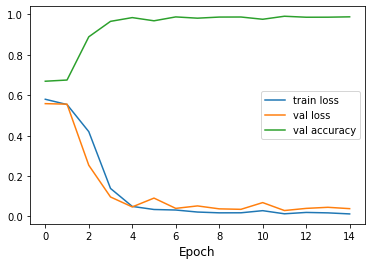

In [9]:
plot_losses(train_loss, valid_loss, valid_acc)

In [10]:
# Check if we're learned how to perform on items in the valid dataset
x, y = valid_ds[10]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([292,  45, 112, 699, 233, 930, 992, 992, 992, 607], device='cuda:0')
y:	 tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
y_hat:	 tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')


### Longer Sequences

Let's try to train on longer sequences. We'll first train on the "easy" problem of a sequence of length 10 then train the model on the "hard" problem of a sequence of length 100.

In [11]:
TRN_EXAMPLES = 10000
VAL_EXAMPLES = 1000
SEQUENCE_LENGTH = 10
VOCAB_SIZE = 1000
BATCH_SIZE = 32

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [12]:
model = ToyModel(VOCAB_SIZE)
model = model.cuda()

optimizer = RAdam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
train_loss, valid_loss, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15)

Epoch:	 0 	Step:	 0 	Loss:	 0.9250129461288452
Epoch:	 0 	Step:	 100 	Loss:	 0.5955852270126343
Epoch:	 0 	Step:	 200 	Loss:	 0.5816855430603027
Epoch:	 0 	Step:	 300 	Loss:	 0.5760510563850403
Epoch:	 0 			Valid Accuracy	 0.66445315
Epoch:	 1 	Step:	 0 	Loss:	 0.5530246496200562
Epoch:	 1 	Step:	 100 	Loss:	 0.5733128190040588
Epoch:	 1 	Step:	 200 	Loss:	 0.5920308828353882
Epoch:	 1 	Step:	 300 	Loss:	 0.5701488256454468
Epoch:	 1 			Valid Accuracy	 0.6817383
Epoch:	 2 	Step:	 0 	Loss:	 0.5380566120147705
Epoch:	 2 	Step:	 100 	Loss:	 0.5614832639694214
Epoch:	 2 	Step:	 200 	Loss:	 0.5434988141059875
Epoch:	 2 	Step:	 300 	Loss:	 0.46481695771217346
Epoch:	 2 			Valid Accuracy	 0.80996096
Epoch:	 3 	Step:	 0 	Loss:	 0.35209327936172485
Epoch:	 3 	Step:	 100 	Loss:	 0.1793084442615509
Epoch:	 3 	Step:	 200 	Loss:	 0.17567577958106995
Epoch:	 3 	Step:	 300 	Loss:	 0.13645941019058228
Epoch:	 3 			Valid Accuracy	 0.9751953
Epoch:	 4 	Step:	 0 	Loss:	 0.053748197853565216
Epoch:	 4 	St

In [14]:
SEQUENCE_LENGTH = 100

train_ds = ToyDataset(num_examples=TRN_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
valid_ds = ToyDataset(num_examples=VAL_EXAMPLES, sequence_length=SEQUENCE_LENGTH, vocab_size=VOCAB_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

optimizer = RAdam(model.parameters(), lr=1e-5)
train_loss, valid_loss, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, num_epochs=15)

Epoch:	 0 	Step:	 0 	Loss:	 0.9379016757011414
Epoch:	 0 	Step:	 100 	Loss:	 0.16653968393802643
Epoch:	 0 	Step:	 200 	Loss:	 0.154115229845047
Epoch:	 0 	Step:	 300 	Loss:	 0.14558014273643494
Epoch:	 0 			Valid Accuracy	 0.96512693
Epoch:	 1 	Step:	 0 	Loss:	 0.14455558359622955
Epoch:	 1 	Step:	 100 	Loss:	 0.1411665976047516
Epoch:	 1 	Step:	 200 	Loss:	 0.14367051422595978
Epoch:	 1 	Step:	 300 	Loss:	 0.13851766288280487
Epoch:	 1 			Valid Accuracy	 0.9657422
Epoch:	 2 	Step:	 0 	Loss:	 0.12604351341724396
Epoch:	 2 	Step:	 100 	Loss:	 0.12480984628200531
Epoch:	 2 	Step:	 200 	Loss:	 0.12089099735021591
Epoch:	 2 	Step:	 300 	Loss:	 0.1095748022198677
Epoch:	 2 			Valid Accuracy	 0.9663867
Epoch:	 3 	Step:	 0 	Loss:	 0.09278164058923721
Epoch:	 3 	Step:	 100 	Loss:	 0.08953101933002472
Epoch:	 3 	Step:	 200 	Loss:	 0.08794236928224564
Epoch:	 3 	Step:	 300 	Loss:	 0.07854132354259491
Epoch:	 3 			Valid Accuracy	 0.97169924
Epoch:	 4 	Step:	 0 	Loss:	 0.06345358490943909
Epoch:	

In [15]:
# Check if we're learned how to perform on items in the valid dataset
x, y = valid_ds[19]
y_hat = get_output_for_example(model, x)

print("X:\t", x)
print("y:\t", y)
print("y_hat:\t", y_hat.squeeze())

X:	 tensor([402, 382, 182, 505, 657,  36, 765, 143, 802, 247, 232, 922, 215, 175,
        964, 252, 127, 479, 731,  94, 713, 230, 376, 711, 632, 716, 197, 197,
        197, 349, 606, 296, 646, 936, 782, 795, 360, 542, 465, 544, 237, 514,
        875, 894, 696,  68, 525, 351, 833, 289, 385, 260, 754, 545, 479, 999,
        484, 758, 472, 297, 344, 907, 230, 528, 380,   9, 657, 926, 167, 822,
        455, 741, 480, 764, 450, 225,  34, 987, 930, 285, 571, 571, 315, 889,
        278, 472, 897,  67, 668,  12, 902, 370,  86, 288,  48, 921, 126, 458,
        133, 267], device='cuda:0')
y:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
y_hat:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 